# Quickstart Example with Synthetic RTB Simulation and Dataset (Discrete)
This notebook provides an example of conducting **Off-policy Evaluation (OPE) and Offline Reinforcement Learning (Offline RL) with synthetic Real-Time Bidding (RTB) dataset**.

Our example with Synthetic RTB Simualtion and Dataset contains the following 5 steps:
0. (Setup Synthetic RTB Simulation Environment and Online RL)
1. Synthetic Data Generation
2. Offline Reinforcement Learning
3. Off-Policy Evaluation and Evaluation of Offline RL methods
4. Evaluation of OPE methods

We also show how to visualize the results in Appendix.

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of online/offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [75]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [40]:
# import _gym modules
import _gym
from _gym.env import RTBEnv, CustomizedRTBEnv
from _gym.dataset import SyntheticDataset
from _gym.policy import OnlineHead, DiscreteEpsilonGreedyHead

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [27]:
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(_gym.__version__)

0.0.0


## 0. (Setup Synthetic RTB Simulation Environment and Online RL)
To begin with, we briefly describe how the RTB environment works for the preparation.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as numbers of click or conversion) within a episode under the given budget constraints.  
We often try to achieve this by adjusting bidding price function parameter :math:`\alpha`. By using :math:`\alpha`, we adjust bid price as follows.  
:math:`bid_{t,i} = \alpha * r*`, 
where :math:`r*` denotes predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe statistical feedback from environment at each timestep, which include following informations.
  - timestep
  - remaining budget
  - impression level features (budget comsuption rate, cost per mille of impressions, auction winning rate, reward) at previous timestep
  - adjust rate (RL agent's decision making) at previous timestep
- `action`: Agent chooses adjust rate parameter :math:`\alpha` to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

Let's see how it works!

In [7]:
# setup environment
env = RTBEnv()

In [8]:
# define random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    )
)

In [9]:
# interact agent with environment
# only 6 lines needed for RL interaction
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [10]:
# state contains the following statistical feedback from environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


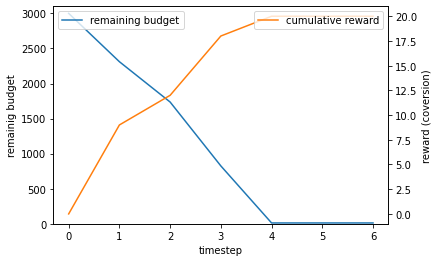

In [11]:
# let's visualize the transition of remaing budget and cumulative reward
# our goal is to gain a policy (i.e., agent) which maximize the cumulative reward under budget constraints using RL.  
# for more visulization, please see appendix.
obs = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

We see that the random policy soon run out the budget.  
Our goal is to derive a policy that controls the adjust rate (i.e., action) to maximize the reward within the given budget constraints.

We have following environmental configurations:
- `objective`: Objective KPIs of RTB, which is either "click" or "conversion".
- `step_per_episode`: Number of timesteps in an episode.
- `initial_budget`: Initial budget (i.e., constraint) for bidding during an episode.
- `n_ads`: Number of ads used for auction bidding.
- `n_users`: Number of users used for auction bidding.
- `ad_feature_dim`: Dimensions of the ad feature vectors.
- `user_feature_dim`: Dimensions of the user feature vectors.
- `ad_sampling_rate`: Sampling probalities to determine which ad (id) is used in each auction.
- `user_sampling_rate`: Sampling probalities to determine which user (id) is used in each auction.
- `standard_bid_price_distribution`: Distribution of the bid price whose average impression probability is expected to be 0.5.
- `minimum_standard_bid_price`: Minimum value for standard bid price.
- `trend_interval`: Length of the CTR/CVR trend cycle, where we define CTR as click per impression and CVR as conversion per click.
- `search_volume_distribution`: Search volume distribution for each timestep.
- `minimum_search_volume`: Minimum search volume at each timestep.
- `random_state`: Random state.

Please also see `_gym/env/rtb.py` for details.

#### Customization of RTB Env from decison makers' perspective
Here, we describe how the decision makers customize their own RTB environment.  
Specifically, they can setup their own action space and bid price calculation rules by defining the following modules.
- `reward_predictor` in Bidder class  
    We use predicted rewards to calculate bid price.  
        bid price = adjust rate * predicted reward ( * constant)
    If None, we use ground-truth reward instead of predicted reward.  

- `scaler` in Bidder class
    Scaler defines constant in the bid price calculation.  
        bid price = adjust rate * predicted reward ( * constant)
        constant = scaler * standard_bid_price
    where standard_bid_price indicates the average of standard_bid_price  
    (bid price which has approximately 50% impression probability) over all ads.

- `action_space` for agent  
    We transform continual adjust rate space [0, \infty) into agent action space [0.1, 10].  
    Both discrete and continuous actions are acceptable.  
    (We can tune multiplication of adjust rate using scaler.)
    
The arguments are given as follows:
- `original_env`: Original RTB Environment.
- `reward_predictor`: A machine learning model to predict the reward to determine the bidding price.
- `scaler`: Scaling factor (constant value) used for bid price determination. (`None` for the auto-fitting)
- `action_type`: Action type of the RL agent, which is either "discrete" or "continuous".
- `action_dim`: Dimention of "discrete" action.
- `action_meaning`: Mapping function of agent action index to the actual "discrete" action to take.

In [12]:
# now, let's customize the environment and discretize action space
env = CustomizedRTBEnv(
    original_env=env,
    reward_predictor=LogisticRegression(),
    action_type="discrete",
)

In [13]:
agent = OnlineHead(DiscreteRandomPolicy())
agent.build_with_env(env)  # set discrete action space

In [14]:
# interact agent with environment
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [15]:
print(env.action_space)
print(env.action_meaning)

Discrete(10)
[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


#### Online RL and comparison of the policies
Noe, we learn an online RL policy and compare it to random policy, using on-policy policy estimation.

In [16]:
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

/home/haa/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
)

In [ ]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [18]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2021-10-13 10:48.48 [warning  ] Parameters will be reinitialized.


Text(0, 0.5, 'episode reward')

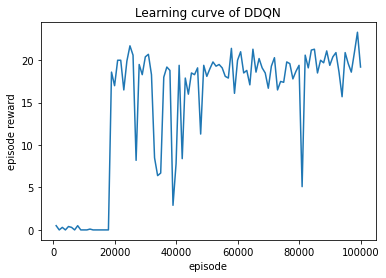

In [19]:
df = pd.read_csv(
    "d3rlpy_logs/DoubleDQN_online_20211005174755/evaluation.csv", 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of DDQN")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [20]:
def calc_on_policy_policy_value(env, agent, n_episodes=100):
    
    agent = OnlineHead(agent)
    on_policy_policy_value = 0
    
    for i in range(n_episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.predict_online(state)
            next_state, reward, done, _ = env.step(action)
            on_policy_policy_value += reward

    return on_policy_policy_value / n_episodes

In [53]:
# on-policy policy value by dqn policy
ddqn_performance = calc_on_policy_policy_value(env, ddqn)
ddqn_performance

17.39

In [55]:
# on-policy policy value by random policy
random = DiscreteRandomPolicy()
random.build_with_env(env)

random_performance = calc_on_policy_policy_value(env, random)
random_performance

16.19

In [56]:
# approximately 10% of improvement on policy value
print("relative improvement:", (dqn_performance - random_performance) / random_performance)

relative improvement: 0.13279802347127848


## 1. Synthetic Dataset Generation
In the previous section, we see how we can interact the environment *online* using synthetic simulator.  
Though simulation is a good start for training agent, eventually we want to deploy our agent (or policy) in the real world environment.  
However, online interaction may have potential risk of failure in real-world implementataion.  
Therefore, we introduce alternative learning protocol, Offline RL, which aim to obtain a new policy using only offline logged dataset.

We prepare easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding simulation environment as a hypothetical real-environment, we show how to conduct Offline RL using logged dataset in real-world application.  
For detailed description of how to use real-world dataset, please see #TODO (will be implemented).

We have following arguments for `SyntheticDataset` class:
- `env`: RTB environment for RL defined in the previous section.
- `bahavior_policy`: RL agent (or algorithm) used for the data collection.
- `n_samples_pretrain_reward_predictor`: Numbers of samples used to pretrain reward predictor.

In [24]:
behavior_policy = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
)

In [25]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
)

In [26]:
# collect logged data using behavior policy
# skip if there is a preserved logged dataset
logged_dataset = dataset.obtain_trajectories(n_episodes=10000)

[obtain_trajectories]: 100%|██████████| 10000/10000 [05:00<00:00, 33.32it/s]


In [28]:
logged_dataset

{'size': 70000,
 'n_episodes': 10000,
 'step_per_episode': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 6.98644435e-01, ...,
         6.00790698e-01, 0.00000000e+00, 3.66237388e+00],
        [1.00000000e+00, 2.22900000e+03, 2.57000000e-01, ...,
         9.94708995e-01, 6.00000000e+00, 2.15443469e+00],
        [2.00000000e+00, 2.22900000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 5.52000000e+02, 5.27397260e-01, ...,
         1.00000000e+00, 5.00000000e+00, 5.99484250e+00],
        [5.00000000e+00, 

In [30]:
with open("logs/dataset_discrete.pkl", "wb") as f:
    pickle.dump(logged_dataset, f)

In [32]:
with open("logs/dataset_discrete.pkl", "rb") as f:
    logged_dataset = pickle.load(f)

In [33]:
# on-policy policy value of behavior policy (epsilon_greedy case)
dataset.calc_on_policy_policy_value(n_episodes=100)

[calc_on_policy_policy_value]: 100%|██████████| 100/100 [00:02<00:00, 35.68it/s]


19.17

In [34]:
# check statistics of the dataset
# for more info, please refer the visualization in appendix
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,2.974613,157.034673,83.055543,8.601714,2.649314,0.470024,0.057435,0.152829
std,3.736818,188.175197,91.733713,9.970527,3.681721,0.445320,0.072413,0.200599
min,0.000019,3.859296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.278256,13.646406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.291550,94.671612,17.000000,1.000000,0.000000,0.381743,0.051546,0.000000
75%,3.593814,202.851496,186.000000,18.000000,5.000000,1.000000,0.105028,0.285714
max,10.777099,570.111111,263.000000,43.000000,24.000000,1.000000,0.999997,0.999999


## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting to the environment.  
To achieve this goal, we exploit logged dataset and train the policy on the data.  
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of algorithms.

In [43]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL
from d3rlpy.ope import DiscreteFQE
from d3rlpy.metrics.scorer import evaluate_on_environment

In [44]:
offlinerl_dataset = MDPDataset(
    observations=logged_dataset["state"],
    actions=logged_dataset["action"],
    rewards=logged_dataset["reward"],
    terminals=logged_dataset["done"],
    episode_terminals=logged_dataset["done"],
    discrete_action=True,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2)

In [ ]:
# Use Conservetive Q-Learning policy
cql = DiscreteCQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [45]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={
        'environment': evaluate_on_environment(env),
        # to record training process w/ ground truth policy value, which is unseen to the agent
    },
)

2021-10-13 11:09.00 [warning  ] Unused arguments are passed.   n_epochs=10
2021-10-13 11:09.00 [debug    ] RandomIterator is selected.
2021-10-13 11:09.00 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20211013110900
2021-10-13 11:09.00 [debug    ] Building models...
2021-10-13 11:09.00 [debug    ] Models have been built.
2021-10-13 11:09.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20211013110900/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-10-13 11:11.10 [info     ] DiscreteCQL_20211013110900: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000597909951210022, 'time_algorithm_update': 0.011344913792610168, 'loss': 24.70615148973465, 'time_step': 0.01252389669418335, 'environment': 17.9} step=10000
2021-10-13 11:11.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20211013110900/model_10000.pt


[(1,
  {'time_sample_batch': 0.000597909951210022,
   'time_algorithm_update': 0.011344913792610168,
   'loss': 24.70615148973465,
   'time_step': 0.01252389669418335,
   'environment': 17.9})]

In [46]:
# save model
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [48]:
# reload model
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

2021-10-13 11:13.53 [warning  ] Parameters will be reinitialized.


In [54]:
# on-policy policy value by cql policy
# compared to ddqn (online policy), cql (offline policy) gained almost the same performance,
# without interacting to the actual environment
print("ddqn:", ddqn_performance)

cql_performance = calc_on_policy_policy_value(env, cql)
print("cql:", cql_performance)

ddqn: 17.39
cql: 17.89


## 3. Off-Policy Evaluation and Evaluation of Offline RL methods
In the previous section, we verified the performance of learned policy via online interaction (aka A/B tests).  
However, it could be risky because the policy may perform poorly in an online environment.  
To tackle this issue, we aim to evaluate the performance of policies in an offline manner, to gain prior knowledge on how agent works in the environment.

In [57]:
# import ope modules from _gym
from _gym.ope import CreateOPEInput
from _gym.ope import OffPolicyEvaluation as OPE
from _gym.ope import DiscreteDirectMethod as DM
from _gym.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from _gym.ope import DiscreteStepWiseImportanceSampling as SIS
from _gym.ope import DiscreteDoublyRobust as DR

In [61]:
# define evaluation policies
cql_ = DiscreteEpsilonGreedyHead(base_algo=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0)
ddqn_ = DiscreteEpsilonGreedyHead(base_algo=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0)
random_ = DiscreteEpsilonGreedyHead(base_algo=ddqn, n_actions=env.action_space.n, name="random", epsilon=1.0)
evaluation_policies = [cql_, ddqn_, random_]

In [60]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    logged_dataset=logged_dataset,
    use_base_model=True,  # use model-based prediction
)

In [62]:
# takes time
input_dict = prep.obtain_whole_inputs(
    evaluation_policies=evaluation_policies,
    env=env,
)

[fit FQE model]:   0%|          | 0/3 [00:00<?, ?it/s]

2021-10-13 11:32.52 [debug    ] RandomIterator is selected.
2021-10-13 11:32.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20211013113252
2021-10-13 11:32.52 [debug    ] Building models...
2021-10-13 11:32.52 [debug    ] Models have been built.
2021-10-13 11:32.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20211013113252/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gp

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-10-13 11:34.59 [info     ] DiscreteFQE_20211013113252: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.001658825707435608, 'time_algorithm_update': 0.009904552817344665, 'loss': 2.4812289158582685, 'time_step': 0.012174209475517273} step=10000
2021-10-13 11:34.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20211013113252/model_10000.pt


[fit FQE model]:  33%|███▎      | 1/3 [02:07<04:15, 127.61s/it]

2021-10-13 11:34.59 [debug    ] RandomIterator is selected.
2021-10-13 11:34.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20211013113459
2021-10-13 11:34.59 [debug    ] Building models...
2021-10-13 11:34.59 [debug    ] Models have been built.
2021-10-13 11:34.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20211013113459/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gp

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-10-13 11:37.01 [info     ] DiscreteFQE_20211013113459: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0016055456161499023, 'time_algorithm_update': 0.009517840147018432, 'loss': 2.3405402466356753, 'time_step': 0.011721952199935912} step=10000
2021-10-13 11:37.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20211013113459/model_10000.pt


[fit FQE model]:  67%|██████▋   | 2/3 [04:09<02:04, 124.18s/it]

2021-10-13 11:37.01 [debug    ] RandomIterator is selected.
2021-10-13 11:37.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20211013113701
2021-10-13 11:37.01 [debug    ] Building models...
2021-10-13 11:37.01 [debug    ] Models have been built.
2021-10-13 11:37.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20211013113701/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gp

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-10-13 11:39.03 [info     ] DiscreteFQE_20211013113701: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0016546148300170898, 'time_algorithm_update': 0.009519244194030762, 'loss': 3.244912114071846, 'time_step': 0.011786295342445373} step=10000
2021-10-13 11:39.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20211013113701/model_10000.pt


[collect input data]: 100%|██████████| 3/3 [00:39<00:00, 13.22s/it]


In [ ]:
with open("logs/ope_input_dict_discrete.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [ ]:
with open("logs/ope_input_dict_discrete.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [63]:
ope = OPE(
    logged_dataset=logged_dataset,
    ope_estimators=[DM(), TIS(), SIS(), DR()],
)

In [64]:
# performance estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict)

In [66]:
# estimated policy performance
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy     18.380000               1.000000
 dm            14.604004               0.794560
 tis           12.560904               0.683401
 sis           37.730018               2.052776
 dr            14.738042               0.801852,
 'ddqn':            policy_value  relative_policy_value
 on_policy     19.810000               1.000000
 dm            10.285681               0.519217
 tis          828.378882              41.816198
 sis          259.281915              13.088436
 dr           133.114436               6.719558,
 'random':            policy_value  relative_policy_value
 on_policy     15.660000               1.000000
 dm             9.900794               0.632235
 tis           13.759908               0.878666
 sis           20.064407               1.281252
 dr            17.779842               1.135367}

In [67]:
# estimated policy performance confidence intervals
policy_value_interval_df_dict

{'cql':           mean  95.0% CI (lower)  95.0% CI (upper)
 dm   14.603930         14.602850         14.605248
 tis  12.435295          0.000000         37.682712
 sis  37.279325         30.059431         46.715131
 dr   14.724193         11.666717         18.864795,
 'ddqn':            mean  95.0% CI (lower)  95.0% CI (upper)
 dm    10.285727         10.285199         10.286348
 tis  822.784638        475.846640       1516.002716
 sis  270.873366        121.254535        476.527075
 dr   141.104541         72.871232        287.024605,
 'random':           mean  95.0% CI (lower)  95.0% CI (upper)
 dm    9.900770          9.900453          9.901168
 tis  13.825765         10.321548         17.545025
 sis  20.470850         17.158490         25.455147
 dr   17.825188         15.759514         20.081552}

## 4. Evaluation of OPE methods
Now, we evaluate how well ope estimators estimated the policy value.

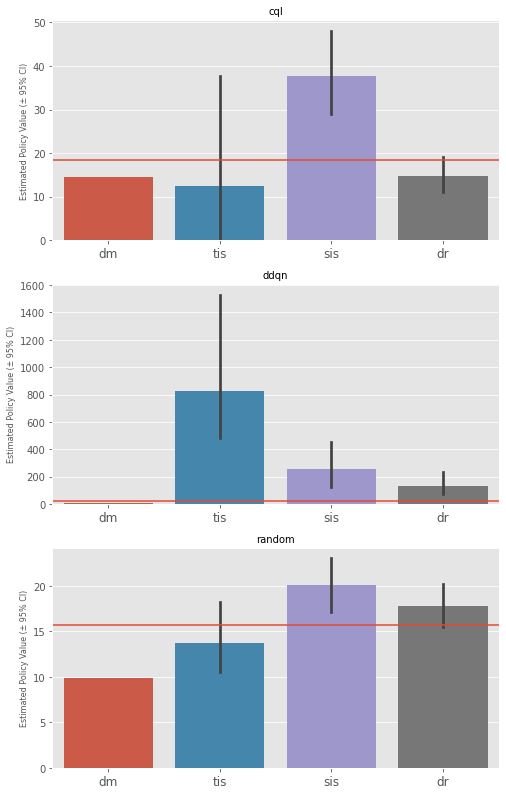

In [98]:
# we can visualize and compare the result
# it seems that DM tends to have a bias though the variance is quite small, 
# while importance sampling estimators have a smaller bias with a larger variance.
# somehow policy evaluation of DDQN policy seems quite hard.
ope.visualize_off_policy_estimates(input_dict)

In [71]:
# squared-error (se) measures the estimation accuracy of OPE
eval_metric_ope_df = ope.summarize_estimators_comparison(input_dict, metric="se")
eval_metric_ope_df

,cql,ddqn,random
dm,14.258145,90.712653,33.168457
tis,33.861880,653783.636960,3.610350
sis,374.423215,57346.798064,19.398801
dr,13.263859,12837.895305,4.493728


## Appendix
Here we provide useful visualization function and insights of Synthetic RTB Simulation environment.

In [95]:
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,2.974613,157.034673,83.055543,8.601714,2.649314,0.470024,0.057435,0.152829
std,3.736818,188.175197,91.733713,9.970527,3.681721,0.445320,0.072413,0.200599
min,0.000019,3.859296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.278256,13.646406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.291550,94.671612,17.000000,1.000000,0.000000,0.381743,0.051546,0.000000
75%,3.593814,202.851496,186.000000,18.000000,5.000000,1.000000,0.105028,0.285714
max,10.777099,570.111111,263.000000,43.000000,24.000000,1.000000,0.999997,0.999999


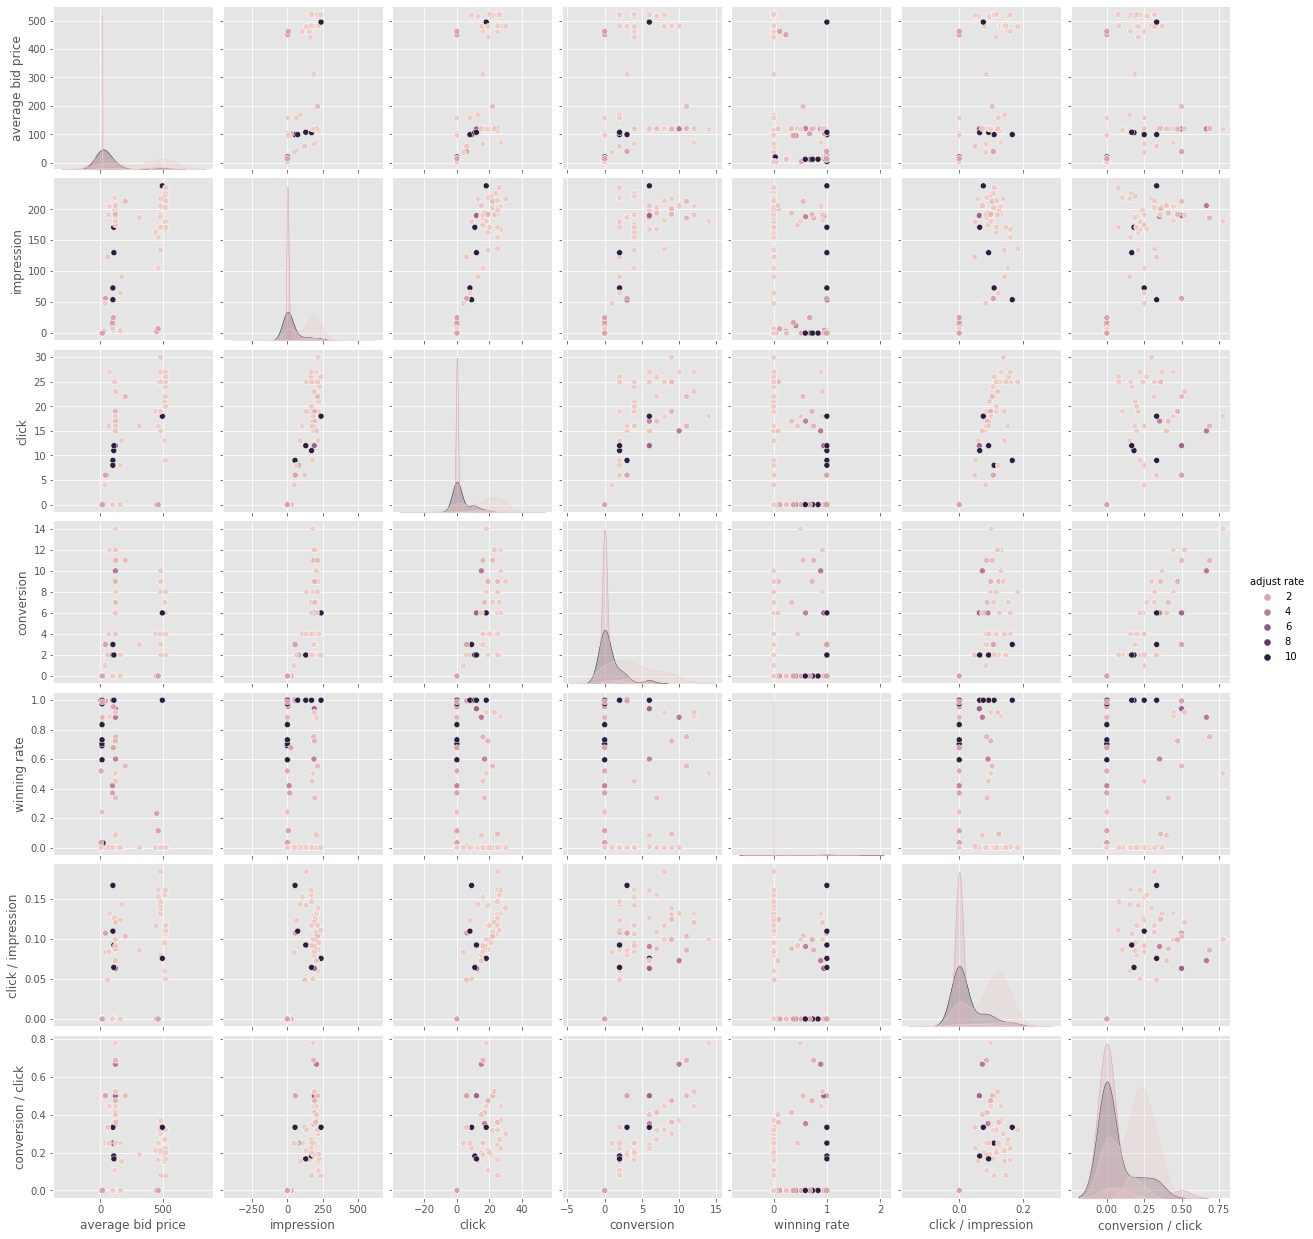

In [77]:
# we see that large adjust rate does not always lead to high reward (conversion) because of the budget constraints
# therefore, it is important to appropriately controling adjust rate parameter by RL policy (agent)
sns.pairplot(df[:100], hue='adjust rate')

In [96]:
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['ramainind budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]

In [97]:
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,ramainind budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.974613,157.034673,83.055543,8.601714,2.649314,173.608500
std,0.802188,40.894621,10.568383,0.663254,0.611892,347.575214
min,0.281743,26.619371,20.714286,2.428571,0.428571,1.000000
25%,2.355495,126.695036,76.571429,8.428571,2.285714,15.000000
50%,3.177621,162.734810,82.857143,8.714286,2.714286,30.000000
75%,3.497884,181.316845,89.714286,9.000000,3.000000,71.000000
max,6.218647,326.902735,126.714286,10.285714,5.000000,2942.000000


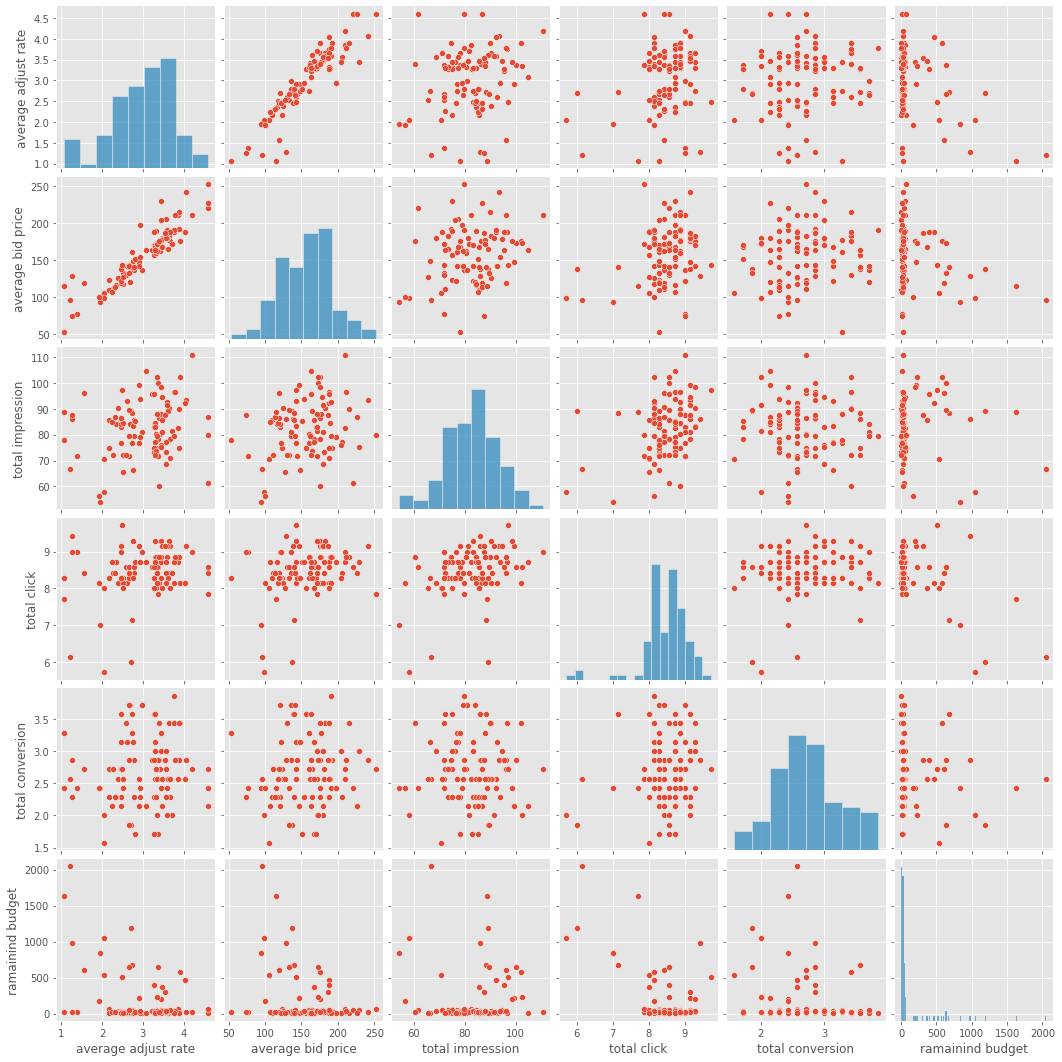

In [88]:
# not so much correlation between adjust rate and conversion, meaning that there are room for improvement
sns.pairplot(df_[:100])